<a href="https://colab.research.google.com/github/flowergum/Colorization/blob/main/Color.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Восстановление цвета чёрно-белых изображений

### Импорты и настройки

In [1]:
import os
import shutil
import tensorflow as tf
import tensorboard as tb
import torch
import math
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import RNN, LSTM
import torchvision
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.nn import init
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, \
                                    Dense, \
                                    MaxPool2D,\
                                    Dropout, \
                                    Flatten, \
                                    BatchNormalization, InputLayer, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from skimage.color import rgb2lab, lab2rgb
from skimage.io import imsave
from google.colab import files
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import glob

import zipfile
import os
from PIL import Image
import matplotlib.pyplot as plt

import cv2

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
!nvidia-smi

Wed May 12 22:12:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    28W /  70W |    222MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Загрузка датасета

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

In [6]:
#скачиваем и распаковываем .zip файл с изображениями для train, делать 1 раз
z = zipfile.ZipFile('/content/drive/MyDrive/Colorization/zip/finish_train.zip', 'r')
img = z.extractall()

In [7]:
#скачиваем и распаковываем .zip файл с изображениями для test, делать 1 раз
z = zipfile.ZipFile('/content/drive/MyDrive/Colorization/zip/finish_test.zip', 'r')
img = z.extractall()

In [8]:
#Параметры для нормировки этого датасета:
mean_L = 45.79130178300922
mean_a = -0.38852695681042315
mean_b = 4.471480806063103
std_L = 26.482664030617855
std_a = 9.891850407715054
std_b = 17.18432487325909

### Создание генератора датасета

In [9]:
def batch_gen(path):
    fileList = os.listdir(path)
    for filepath in fileList:
        img = cv2.imread(path + "/" + filepath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # processed image
        img = np.array(img, dtype=float)
        lab = rgb2lab(1.0/255*img)
        X, Y = lab[:,:,0], lab[:,:,1:]/128
        X = X.reshape(img.shape[0], img.shape[1], 1)
        Y = Y.reshape(img.shape[0], img.shape[1], 2)
        yield X, Y                                    #yield -- приостанавливает выполнение, не прерывает. Подробнее в тексте

def dataset_gen(path, epochs, batch_size):
    dataset = tf.data.Dataset.from_generator(lambda: batch_gen(path),
                                             output_types=(tf.float64, tf.float64))  #тут формируем датасет
    #print(dataset.shape)
    dataset = dataset.repeat(epochs)          #повторяем датасет нужное число раз; н-р, epochs = 2: [1, 2, 3] --> [1, 2, 3, 1, 2, 3]
    dataset = dataset.batch(batch_size)       #формирует пакеты по batch_size штук в каждом
    return dataset

def train_gen(path):
    dataset = tf.data.Dataset.from_generator(lambda: batch_gen(path),
                                             output_types=(tf.float64, tf.float64))  #тут формируем датасет
    return dataset

### Создание тестовой выборки

In [10]:
def processed_image(img):    
  img = np.array(img, dtype=float)   
  size = img.shape
  lab = rgb2lab(1.0/255*img)                
  X, Y = lab[:,:,0], lab[:,:,1:]              
  #Y /= 128    


  X = X.reshape(size[0], size[1], 1)
  Y = Y.reshape(size[0], size[1], 2)
  del size
  return X, Y

In [11]:
#train выборка методами test-выборки
import cv2
x_train = []
y_train = []
#путь к папке с распакованными изображениями
path = '/content/content/all'
fileList = os.listdir(path)
j = 0
for i in fileList:
   file_ = cv2.imread(('/content/content/all/' + i))
   file_ = cv2.cvtColor(file_, cv2.COLOR_BGR2RGB)
   X, Y = processed_image(file_)
   #print(X.shape)
   if X.shape == (128, 128, 1) and Y.shape == (128, 128, 2):
      x_train.append(X)
      y_train.append(Y)
   else:
      print('xexe')
   j += 1
   if j == 9728:
      break

x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape, y_train.shape)

(9728, 128, 128, 1) (9728, 128, 128, 2)


In [12]:
max1 = np.amax(y_train)
min1 = np.amin(y_train)
mean_a = np.mean(y_train[:,:,:,0])
mean_b =np.mean(y_train[:,:,:,1])
std_a = np.std(y_train[:,:,:,0])
std_b = np.std(y_train[:,:,:,1])

In [13]:
y_train[:,:,:,0] = (y_train[:,:,:,0] - np.mean(y_train[:,:,:,0]))/np.std(y_train[:,:,:,0])
y_train[:,:,:,1] = (y_train[:,:,:,1] - np.mean(y_train[:,:,:,1]))/np.std(y_train[:,:,:,1])

In [14]:
import cv2
list_x = []
list_y = []
#путь к папке с распакованными изображениями
path = '/content/content/all1'
fileList = os.listdir(path)
for i in fileList:
   file_ = cv2.imread(('/content/content/all1/' + i))
   file_ = cv2.cvtColor(file_, cv2.COLOR_BGR2RGB)
   X, Y = processed_image(file_)
   #print(X.shape)
   if X.shape == (128, 128, 1) and Y.shape == (128, 128, 2):
      list_x.append(X)
      list_y.append(Y)
   else:
      print('xexe')

In [15]:
list_x = np.array(list_x)
list_y = np.array(list_y)
print(list_x.shape, list_y.shape)

(2153, 128, 128, 1) (2153, 128, 128, 2)


In [16]:
list_y[:,:,:,0] = (list_y[:,:,:,0] - np.mean(list_y[:,:,:,0]))/np.std(list_y[:,:,:,0])
list_y[:,:,:,1] = (list_y[:,:,:,1] - np.mean(list_y[:,:,:,1]))/np.std(list_y[:,:,:,1])

### Создание модели

In [17]:
model = Sequential()                                                      # Последовательная
model.add(InputLayer(input_shape=(None, None, 1)))                        # Входной слой, подаем на вход яркостную компоненту
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))          # Свертка, 64 фильтра
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
#model.add(UpSampling2D((2, 2))) #Растягивает картинку
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
#model.add(UpSampling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
#model.add(BatchNormalization())
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

model.compile(optimizer='adam', loss='mse')
#model.summary()

#### Модель 2, для сравнения

In [18]:
 model2 = Sequential()     #из статьи сравниваю
 model2.add(InputLayer(input_shape=(None, None, 1)))
 model2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
 model2.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
 model2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
 model2.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
 model2.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
 model2.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
 model2.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
 model2.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
 model2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
 model2.add(UpSampling2D((2, 2)))
 model2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
 model2.add(UpSampling2D((2, 2)))
 model2.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
 model2.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
 model2.add(UpSampling2D((2, 2)))

 #model2.compile(optimizer='adam', loss='mse')

In [19]:
# history2 = model2.fit(x=x_train, y=y_train, batch_size=100, epochs=35) #всего 55 эпох (55 -- оптимально: размер изображения: 128*128, 2500 картинок на 5 классов)

### Обучение сети

In [20]:
#model.load_weights("drive/MyDrive/Colorization/weights/2.6_classes_45_epoch_9728_samples.h5")

# Сами разбейте новый объект датасета на тренировочную и тестовую выборку
# history = model.fit(x=x_train1, y=y_train1, batch_size=500, epochs=6, validation_data=(x_test1, y_test1))

In [29]:
train_path = '/content/content/all'
test_path = '/content/content/all1'

epochs = 25
batch_size = 256
total_items = len(os.listdir(train_path))
num_batches = int(total_items/batch_size)
print(f"batch_size={batch_size}\nnum_batches = {num_batches}\ntotal_samples={num_batches*batch_size}\n{'-'*30}")


dataset = dataset_gen(train_path, epochs, batch_size)

history = model.fit(x=x_train, y=y_train, batch_size=256, epochs=60, validation_data=(list_x, list_y))
#history = model.fit(dataset, steps_per_epoch=num_batches, epochs=epochs, validation_data=(list_x, list_y), verbose=1)

batch_size=256
num_batches = 38
total_samples=9728
------------------------------
Epoch 1/20
38/38 [==============================] - 18s 475ms/step - loss: 0.4277 - val_loss: 47.0121
Epoch 2/20
18/38 [=============>................] - ETA: 8s - loss: 0.4256

KeyboardInterrupt: ignored

In [22]:
model.save_weights("drive/MyDrive/Colorization/weights/3.nonormal_6_classes_40_epoch_9728_samples.h5")

#### Вариант обратного преобразования (не допилен)

In [23]:
def one_img_to_model(img):
    img = np.array(img, dtype=float)
    lab = rgb2lab(1.0/255*img)
    X, Y = lab[:,:,0], lab[:,:,1:]/128
    X = X.reshape(img.shape[0], img.shape[1], 1)
    X = np.reshape(X, (1, 128, 128, 1))
    return X

In [24]:
def collect2rgb(l, ab):
    ab *= 128
    lab = np.concatenate((l, ab), axis = 2)
    rgb = lab2rgb(lab)
    return rgb

(128, 128, 1) (128, 128, 2)


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 9776 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 5473 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


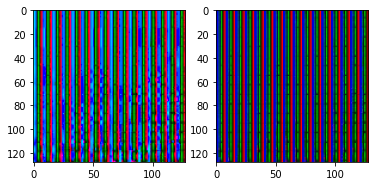

In [25]:
i = 1234

a = np.reshape((list_x[i]), (1, 128, 128, 1))
y_predict = model.predict(a)
print(list_x[i].shape, list_y[i].shape)
real = collect2rgb(list_x[i], list_y[i])

y = np.reshape((y_predict), (128, 128, 2))
predict = collect2rgb(list_x[i], y)
#print(real)
plt.subplot(1, 2, 1)
plt.imshow(real)
plt.subplot(1, 2, 2)
plt.imshow(predict)

#### Без преобразований функциями


In [26]:
print('ДО:')
print('max:', max1)
print('min:', min1)
print('ПОСЛЕ:')
print('max:', np.amax(y_train))
print('min:', np.amin(y_train))

ДО:
max: 64.53265229047373
min: -71.15803981327822
ПОСЛЕ:
max: 9.209182439459614
min: -10.656481148680657


(128, 128, 3)
(1, 128, 128, 1)
(1, 128, 128, 2)


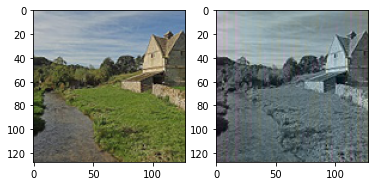

In [27]:
i = 20074
img = Image.open('/content/drive/MyDrive/Colorization/test/' + str(i) + '.jpg')
image = img.resize((128, 128))
#print(np.asarray(img).shape)
#Если захотим посмотреть на кота: "drive/MyDrive/Colorization/2_Natural_Images/data/natural_images/cat/cat_0873.jpg"
#Цветок: "drive/MyDrive/Colorization/1_Flowers/input/flowers/flowers/sun-flower-2593596_960_720.jpg"
imag = np.array(image)
size = imag.shape 
print(size)
img = Image.fromarray(imag)
A, Y = processed_image(img)
X = np.reshape((A), (1, size[0], size[1], 1))
print(X.shape)
output = model.predict(X)
print(output.shape)


output[:,:,:,0] = output[:,:,:,0] * std_a + mean_a

output[:,:,:,1] = output[:,:,:,1] * std_b + mean_b

#output *= (128)
min_vals, max_vals = -128, 127
ab = np.clip(output[0], min_vals, max_vals)

cur = np.zeros((size[0], size[1], 3))
cur[:,:,0] = np.clip(X[0][:,:,0], 0, 100)
cur[:,:,1:] = ab
rgb = lab2rgb(cur)
#rgb[:,:,0] = 
#rgb[:,:,0] = 
#rgb[:,:,0] = 
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(rgb)


# График

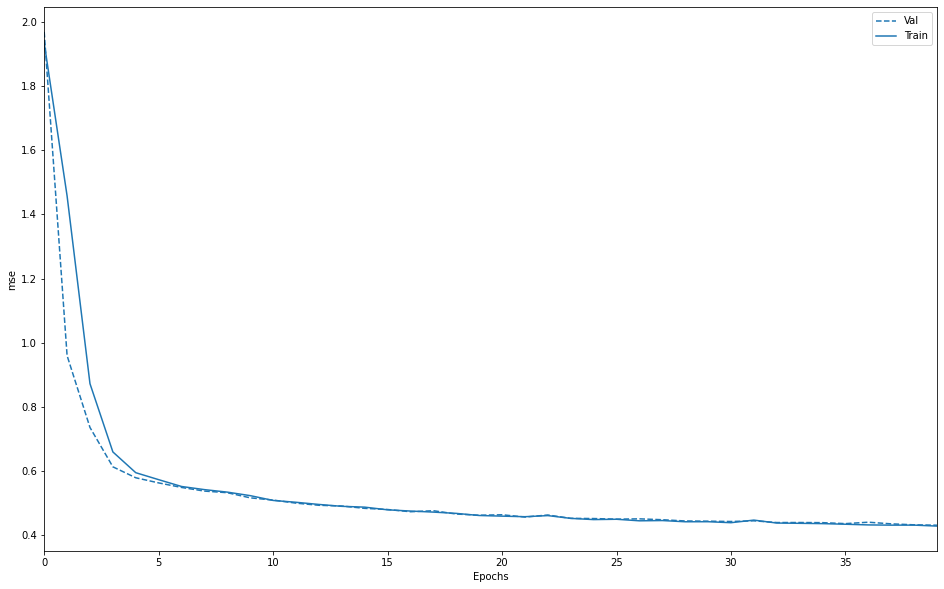

In [28]:
plt.figure(figsize=(16,10))
plt.xlabel('Epochs')
plt.ylabel("mse")
val = plt.plot(history.epoch, history.history['val_'+'loss'],
                   '--', label='Val')
plt.plot(history.epoch, history.history["loss"], color=val[0].get_color(),
             label='Train')
plt.legend()
plt.xlim([0, max(history.epoch)])
#plt.ylim([0,0.02])
plt.savefig('/content/drive/MyDrive/Colorization/graphs/2.6_classes_40_epoch_9728_samples.png')

# Эксперименты

In [ ]:
import zipfile
import os
from PIL import Image
import numpy as np 
import matplotlib.pyplot as plt

#скачиваем и распаковываем .zip файл с изображениями, делать 1 раз
z = zipfile.ZipFile('/content/drive/MyDrive/Colorization/zip/train.zip', 'r')
img = z.extractall()

x_set = []

#путь к папке с распакованными изображениями
path = '/content/train'
fileList = os.listdir(path)
j = 0
for i in fileList:
   file_ = cv2.imread(('/content/train/' + i))
   file_ = cv2.cvtColor(file_, cv2.COLOR_BGR2RGB)
   file_ = np.array(file_, dtype=float)
   image = Image.fromarray(np.uint8(file_)).resize((128, 128))
   image = np.array(image, dtype=float)
   if image.shape!=(128,128,3):
      print('ЧБ')
   else:
      lab = rgb2lab(1.2/255*image)
      x_set.append(lab)
      j=j+1
   if j%100 == 0 or j == 50018 or j == 50019:
      print(j)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900


In [ ]:
z = zipfile.ZipFile('/content/drive/MyDrive/Colorization/zip/test.zip', 'r')
img = z.extractall()
path = '/content/test'
fileList = os.listdir(path)
for i in fileList:
   file_ = cv2.imread(('/content/test/' + i))
   file_ = cv2.cvtColor(file_, cv2.COLOR_BGR2RGB)
   file_ = np.array(file_, dtype=float)
   image = Image.fromarray(np.uint8(file_)).resize((128, 128))
   image = np.array(image, dtype=float)
   if image.shape!=(128,128,3):
      print('ЧБ')
   else:
      lab = rgb2lab(1.2/255*image)
      x_set.append(lab)
      j=j+1
   if j%100 == 0 or j == 50018 or j == 50019:
      print(j)

7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400


In [ ]:
a = np.array(x_set)
#np.random.shuffle(a)
print(type(a))
print(a.shape)

<class 'numpy.ndarray'>
(8410, 128, 128, 3)


In [ ]:
#Узнаем среднее значение и стандартное отклонение каждого канала, сначала переведем в Lab
mean_L = np.mean(a[:,:,:,0])
mean_a = np.mean(a[:,:,:,1])
mean_b = np.mean(a[:,:,:,2])
std_L = np.std(a[:,:,:,0])
std_a = np.std(a[:,:,:,1])
std_b = np.std(a[:,:,:,2])

In [ ]:
print('mean_L =', mean_L)
print('mean_a =', mean_a)
print('mean_b =', mean_b)
print('std_L =', std_L)
print('std_a =', std_a)
print('std_b =', std_b)

mean_L = 53.33792483554244
mean_a = -2.5445305347928766
mean_b = 3.683175451262642
std_L = 31.03467193533188
std_a = 10.684354050077616
std_b = 21.480888462249585


In [ ]:
#по отдельности сделать это

import os
import zipfile
from PIL import Image 

newzip = zipfile.ZipFile('/content/drive/MyDrive/Colorization/zip/finish_test.zip', 'w')
for i in range(2153):
    picture = Image.fromarray(a[i], 'RGB')
    picture = picture.save("/content/all1/img" + str(i+1) + ".jpg")
    newzip.write(r"/content/all1/img" + str(i+1) + ".jpg") #добавляем файл в архив

newzip.close() #закрываем архив